# Social hackathon: Visualize and predicting H1B acceptance
The dataset is H1B data from Kaggle, spanning from 2011 to 2016. We retained only CERTIFIED and DENIED cases, since these are the two major types and easiest to intepret. This dataset is combined with census data to calculate the fractions of H1B in total population of each state. 

The first part is EDA with geographic maps illustrate the distribution of most common jobs  that get accepted/denied accross states (normalized to each state population).

The second part is a classification model to predict the likelihood of getting accepted/rejected for certain H1B case. Due to the extreme balance of  certified vs. denied classes, we upsampled the minority (denied) class. However the AUC is still low (0.59) and there is still room for improvement. Feature importance suggested that wage is the most crucial feature affecting the acceptance decision.


In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 

## EDA

In [5]:
# Import kaggle data set
df = pd.read_csv('h1b_kaggle.csv')

In [3]:
df.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 11 columns):
Unnamed: 0            int64
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE              object
lon                   float64
lat                   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 252.0+ MB


In [6]:
# Subset the data to get Accepted and Denied cases only
sub_df = df[df['CASE_STATUS'].isin(['CERTIFIED','DENIED'])]

In [7]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2709969 entries, 18 to 3002392
Data columns (total 11 columns):
Unnamed: 0            int64
CASE_STATUS           object
EMPLOYER_NAME         object
SOC_NAME              object
JOB_TITLE             object
FULL_TIME_POSITION    object
PREVAILING_WAGE       float64
YEAR                  float64
WORKSITE              object
lon                   float64
lat                   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 248.1+ MB


In [8]:
#Function to count unique values of each column in the data set
def count_unique(df,col):
    return df[col].value_counts()

In [36]:
print('Case Status','\n', count_unique(sub_df,'CASE_STATUS').head(5))
print('\n')
print('Job Title','\n', count_unique(sub_df,'JOB_TITLE').head(5))

Case Status 
 CERTIFIED    2615623
DENIED         94346
Name: CASE_STATUS, dtype: int64


Job Title 
 PROGRAMMER ANALYST     226313
SOFTWARE ENGINEER      105315
COMPUTER PROGRAMMER     65399
SYSTEMS ANALYST         56652
SOFTWARE DEVELOPER      38745
Name: JOB_TITLE, dtype: int64


In [6]:
def hist_plot(df,col,bins):
    plt.figure(figsize=(8,6))
    df[df['CASE_STATUS']=='CERTIFIED'][col].hist(alpha=0.5,color='red',
                                              bins=bins,label='approved')
    df[df['CASE_STATUS']=='DENIED'][col].hist(alpha=0.7,color='blue',bins=bins,label='denied')
    plt.legend(['approved','denied'])
    plt.xlabel(col)
    print('Average %s of converted users is' %col, round(df[df['CASE_STATUS']=='CERTIFIED'][col].mean(),1))
    print('Average %s of non-converted users is' %col,round(df[df['CASE_STATUS']=='DENIED'][col].mean(),1))


In [7]:
def boxplot(df,col):
    
    data_to_plot = [df[df['CASE_STATUS']=='CERTIFIED'][col],df[df['CASE_STATUS']=='DENIED'][col]]
    # Create a figure instance
    fig = plt.figure(figsize=(9, 6))
    # Create an axes instance
    ax = fig.add_subplot(111)
    # Create the boxplot
    ax.boxplot(data_to_plot)
    ax.set_xticklabels(['approved','denied'],fontsize=14)
    plt.ylabel(col,fontsize=14)

In [9]:
# Create a State column from Worksite 
sub_df['STATE'] = sub_df['WORKSITE'].apply(lambda x:x.split(',')[1])

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [10]:
sub_df.head()

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat,STATE
18,19,CERTIFIED,QUICKLOGIX LLC,CHIEF EXECUTIVES,CEO,Y,187200.0,2016.0,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108,CALIFORNIA
19,20,CERTIFIED,"MCCHRYSTAL GROUP, LLC",CHIEF EXECUTIVES,"PRESIDENT, NORTHEAST REGION",Y,241842.0,2016.0,"ALEXANDRIA, VIRGINIA",-77.046921,38.804835,VIRGINIA
22,23,CERTIFIED,"LOMICS, LLC",CHIEF EXECUTIVES,CEO,Y,99986.0,2016.0,"SAN DIEGO, CALIFORNIA",-117.161084,32.715738,CALIFORNIA
23,24,CERTIFIED,UC UNIVERSITY HIGH SCHOOL EDUCATION INC.,CHIEF EXECUTIVES,CHIEF FINANCIAL OFFICER,Y,99986.0,2016.0,"CHULA VISTA, CALIFORNIA",-117.084196,32.640054,CALIFORNIA
25,26,CERTIFIED,"QUICKLOGIX, INC.",CHIEF EXECUTIVES,CEO,Y,187200.0,2016.0,"SANTA CLARA, CALIFORNIA",-121.955236,37.354108,CALIFORNIA


In [37]:
# Print # of levels in each categorical level
print(sub_df['SOC_NAME'].nunique())
print(sub_df['JOB_TITLE'].nunique())
print(sub_df['EMPLOYER_NAME'].nunique())

2056
276706
231603


In [15]:
print(count_unique(sub_df,'JOB_TITLE').head(5))
print('\n')
print(count_unique(sub_df,'SOC_NAME').head(5))

PROGRAMMER ANALYST     226313
SOFTWARE ENGINEER      105315
COMPUTER PROGRAMMER     65399
SYSTEMS ANALYST         56652
SOFTWARE DEVELOPER      38745
Name: JOB_TITLE, dtype: int64


Computer Systems Analysts            271368
Computer Programmers                 205977
SOFTWARE DEVELOPERS, APPLICATIONS    197937
COMPUTER SYSTEMS ANALYSTS            197932
Software Developers, Applications    174187
Name: SOC_NAME, dtype: int64


In [11]:
# Dictionary of state codes. This is used to encode states in our data set
us_state_abbrev = {
    'alabama': 'AL',
    'alaska': 'AK',
    'arizona': 'AZ',
    'arkansas': 'AR',
    'california': 'CA',
    'colorado': 'CO',
    'connecticut': 'CT',
    'delaware': 'DE',
    'district of columbia': 'DC',
    'florida': 'FL',
    'georgia': 'GA',
    'hawaii': 'HI',
    'idaho': 'ID',
    'illinois': 'IL',
    'indiana': 'IN',
    'iowa': 'IA',
    'kansas': 'KS',
    'kentucky': 'KY',
    'louisiana': 'LA',
    'maine': 'ME',
    'maryland': 'MD',
    'massachusetts': 'MA',
    'michigan': 'MI',
    'minnesota': 'MN',
    'mississippi': 'MS',
    'missouri': 'MO',
    'montana': 'MT',
    'nebraska': 'NE',
    'nevada': 'NV',
    'new hampshire': 'NH',
    'new jersey': 'NJ',
    'new mexico': 'NM',
    'new york': 'NY',
    'north carolina': 'NC',
    'north dakota': 'ND',
    'ohio': 'OH',
    'oklahoma': 'OK',
    'oregon': 'OR',
    'pennsylvania': 'PA',
    'rhode island': 'RI',
    'south carolina': 'SC',
    'south dakota': 'SD',
    'tennessee': 'TN',
    'texas': 'TX',
    'utah': 'UT',
    'vermont': 'VT',
    'virginia': 'VA',
    'washington': 'WA',
    'west virginia': 'WV',
    'wisconsin': 'WI',
    'wyoming': 'WY',
}

# Function to encode the states
def code_conversion(df,col):
    Code = []
    for state in df[col]:
        if state.lower().strip(' ') in us_state_abbrev:
            Code.append(us_state_abbrev[state.lower().strip(' ')])
        else:
            Code.append('Null')
    df['CODE'] = Code

In [12]:
# Encoding states
code_conversion(sub_df,'STATE')
# Subset the data with US states only
US = sub_df[sub_df['CODE'] != 'Null']

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [13]:
#Check the full time status of certified cases
US[US['CASE_STATUS']=='CERTIFIED']['FULL_TIME_POSITION'].value_counts()

Y    2244485
N     367333
Name: FULL_TIME_POSITION, dtype: int64

In [14]:
# Aggregate data by state, year, status, and job. Order by and print out top 3 job counts. 
df = US.groupby(['CODE','YEAR','CASE_STATUS','SOC_NAME'])['JOB_TITLE'].count().reset_index()
df.columns = ['CODE','YEAR','CASE_STATUS','SOC_NAME','COUNT']
df_agg = df.groupby(['CODE','YEAR','CASE_STATUS','SOC_NAME']).agg({'COUNT':sum})
g = df_agg['COUNT'].groupby(level=[0,1,2], group_keys=False).nlargest(3).reset_index()
g.head()

,CODE,YEAR,CASE_STATUS,SOC_NAME,COUNT
0,AK,2011.0,CERTIFIED,Geological and Petroleum Technicians,8
1,AK,2011.0,CERTIFIED,Accountants and Auditors,4
2,AK,2011.0,CERTIFIED,Computer Programmers,4
3,AK,2011.0,DENIED,"Physicians and Surgeons, All Other",6
4,AK,2011.0,DENIED,Financial Managers,5


In [15]:
#Create a text column that aggregate job name and count
g['TEXT'] = g['SOC_NAME'].apply(lambda x:x.replace(',','')) + ' ' + g['COUNT'].map(str)
g1 = g.groupby(['CODE','YEAR','CASE_STATUS'])['TEXT'].apply('<br>'.join).reset_index()
g1['TEXT'] = g1['CODE'] + '<br>' + g1['TEXT']
# Create a column of total counts by state, year, and status
g1['TOTAL'] = g.groupby(['CODE','YEAR','CASE_STATUS'])['COUNT'].sum().reset_index()['COUNT']
g1.head()

,CODE,YEAR,CASE_STATUS,TEXT,TOTAL
0,AK,2011.0,CERTIFIED,AK<br>Geological and Petroleum Technicians 8<b...,16
1,AK,2011.0,DENIED,AK<br>Physicians and Surgeons All Other 6<br>F...,14
2,AK,2012.0,CERTIFIED,AK<br>Computer Systems Analysts 28<br>Accounta...,50
3,AK,2012.0,DENIED,AK<br>Teachers and Instructors All Other* 5<br...,10
4,AK,2013.0,CERTIFIED,AK<br>Computer Systems Analysts 54<br>Accounta...,73


In [16]:
# Import census data of estimated state population from 2010 to 2017
census = pd.read_csv('nst-est2017-popchg2010_2017.csv')
# Get data from 2011-2016 only
census.drop(['STATE','ESTIMATESBASE2010','POPESTIMATE2010','POPESTIMATE2017'],1,inplace=True)
# Change NAME column to STATE
census = census.rename(columns = {'NAME':'STATE'})
# Encode States
code_conversion(census,'STATE')
# Pivot census table to get population in each year for each state
keys = [c for c in census if c.startswith('POP')]
census = pd.melt(census, id_vars=['STATE','CODE'], value_vars=keys, value_name='POP')
census['YEAR'] = census['variable'].apply(lambda x:int(x[-4:]))
census.head()

,STATE,CODE,variable,POP,YEAR
0,Alabama,AL,POPESTIMATE2011,4798649,2011
1,Alaska,AK,POPESTIMATE2011,722259,2011
2,Arizona,AZ,POPESTIMATE2011,6465488,2011
3,Arkansas,AR,POPESTIMATE2011,2938640,2011
4,California,CA,POPESTIMATE2011,37672654,2011


In [17]:
# left join two tables together on 'CODE'
g1_census = pd.merge(g1,census,how='left',on=['CODE','YEAR'])
# Calculate the fraction of H1B in total population for each state in each year
g1_census['PERCENT'] = g1_census['TOTAL']/g1_census['POP'] * 100
g1_census.head()

,CODE,YEAR,CASE_STATUS,TEXT,TOTAL,STATE,variable,POP,PERCENT
0,AK,2011,CERTIFIED,AK<br>Geological and Petroleum Technicians 8<b...,16,Alaska,POPESTIMATE2011,722259,0.002215
1,AK,2011,DENIED,AK<br>Physicians and Surgeons All Other 6<br>F...,14,Alaska,POPESTIMATE2011,722259,0.001938
2,AK,2012,CERTIFIED,AK<br>Computer Systems Analysts 28<br>Accounta...,50,Alaska,POPESTIMATE2012,730825,0.006842
3,AK,2012,DENIED,AK<br>Teachers and Instructors All Other* 5<br...,10,Alaska,POPESTIMATE2012,730825,0.001368
4,AK,2013,CERTIFIED,AK<br>Computer Systems Analysts 54<br>Accounta...,73,Alaska,POPESTIMATE2013,736760,0.009908


In [18]:
# percentages of total submitted cases each year by state
total = g1_census.groupby(['CODE','YEAR'])['PERCENT'].sum().reset_index()

In [19]:
def geoplot_year(df,year,status,values,title):
    """
    This function plot a geographical map of H1B distribution across states 
    df is the processed data frame g1
    year: 2011 - 2016
    status: 'DENIED' or 'CERTIFIED'
    title: 'denied' or 'accepted'
    """
    if status == 'Null':
        df = df[df['YEAR']==year]
        df['TEXT'] = df['CODE']
    else:
        df = df[(df['YEAR'] == year)&(df['CASE_STATUS']==status)]
    data = dict(type='choropleth',
            colorscale = 'YIOrRd',
            locations = df['CODE'],
            z = df[values],
            locationmode = 'USA-states',
            text = df['TEXT'],
            marker = dict(line = dict(color = 'rgb(255,255,255)',width = 2)),
            colorbar = {'title':"%"}
            ) 
    layout = dict(title = '%d Percentage of H1B cases %s by state population' %(year,title),
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )
    choromap = go.Figure(data = [data],layout = layout)
    iplot(choromap)

In [26]:
geoplot_year(g1_census,2016,'CERTIFIED','PERCENT','accepted')
geoplot_year(g1_census,2016,'DENIED','PERCENT','denied')

In [19]:
# Plot the % of total H1B cases in each state (normalized to state population)
geoplot_year(total,2016,'Null','PERCENT','Submitted')

/Users/uyennguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



# Build the predictor
Given a set of features, this will predict how likely a case will be accepted.
Due to a mix of categorical and continuous variables, a tree-based model is chosen.
Label encoder is applied to deal with categorical features.
Two classes of CASE STATUS are predicted (CERTIFIED = 0 and DENIED = 1)

In [297]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import itertools
from imblearn.over_sampling import RandomOverSampler


## Functions to plot classification metrics

In [355]:
def plot_confusion_matrix(cm, y_test,model_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('Classification report','\n',classification_report(y_test,model_pred))
    print('\n')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [351]:
def plot_feature_importance(model):
    
    fig = plt.figure(figsize=(18, 10))
    ax = fig.add_subplot(111)
    
    #If the model used is tree-based
    df_f = pd.DataFrame(model.feature_importances_, columns=["importance"])
           
    # Display table and plot of the feature importance 
    df_f["labels"] = features
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(5))
    index = np.arange(df_f.shape[0])

    bar_width = 0.5
    rects = plt.barh(index , df_f["importance"], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"],fontsize=30)
    plt.xticks(fontsize=30)

In [353]:
def plot_ROC(model,y_test,model_pred):
    """
    This function plots the ROC curve and print out AUC
    """
    probs = model.predict_proba(X_test)
    cm = pd.DataFrame(confusion_matrix(y_test, model_pred),
                                columns=["Predicted False", "Predicted True"], 
                                index=["Actual False", "Actual True"])
    display(cm)

    # Calculate the fpr and tpr for all thresholds of the classification
    plt.figure(figsize=(10,6))
    fpr, tpr, threshold = roc_curve(y_test, probs[:,1])
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.xlabel('False Positive Rate',fontsize=14)
    print('Area under the curve is %f' %roc_auc_score(y_test,model_pred))

In [303]:
sub_df.columns

Index(['Unnamed: 0', 'CASE_STATUS', 'EMPLOYER_NAME', 'SOC_NAME', 'JOB_TITLE',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'WORKSITE', 'lon',
       'lat', 'STATE', 'CODE', 'col'],
      dtype='object')

In [323]:
# Convert the categorical feature to numeric feature
def label_encoder(df,col):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.codes

cols = ['CASE_STATUS','CODE','SOC_NAME','FULL_TIME_POSITION','EMPLOYER_NAME','JOB_TITLE']
for col in cols:
    label_encoder(sub_df,col)

In [333]:
sub_df.dropna(inplace=True)

In [367]:
# Prepare to build model, start with train, test splitting
X = sub_df[['CODE','SOC_NAME','FULL_TIME_POSITION','EMPLOYER_NAME','JOB_TITLE','PREVAILING_WAGE']]
y = sub_df['CASE_STATUS']
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [368]:
# Oversampling the minor class (status = 1, denied)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [369]:
dtree = DecisionTreeClassifier()
dtree.fit(X_resampled,y_resampled)
dtree_pred = dtree.predict(X_test)

,importance,labels
5,0.288879,PREVAILING_WAGE
3,0.264303,EMPLOYER_NAME
4,0.189793,JOB_TITLE
1,0.151803,SOC_NAME
0,0.094844,CODE


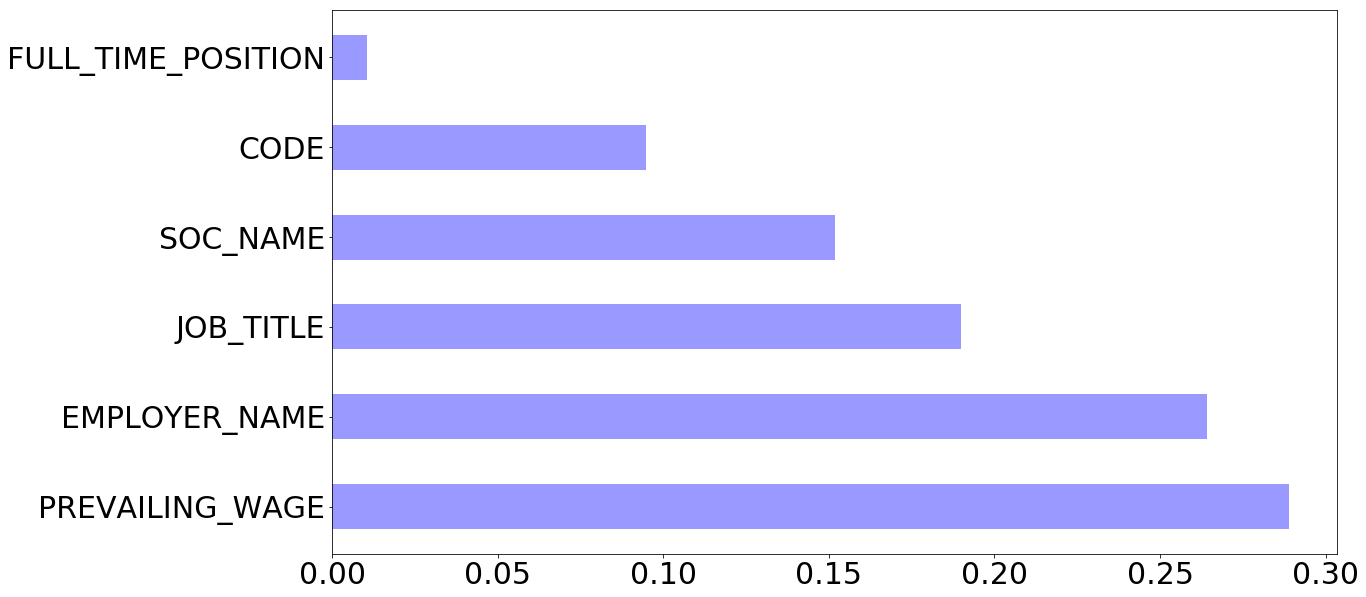

In [370]:
plot_feature_importance(dtree)

,Predicted False,Predicted True
Actual False,478600,26896
Actual True,13035,4040


Area under the curve is 0.591698


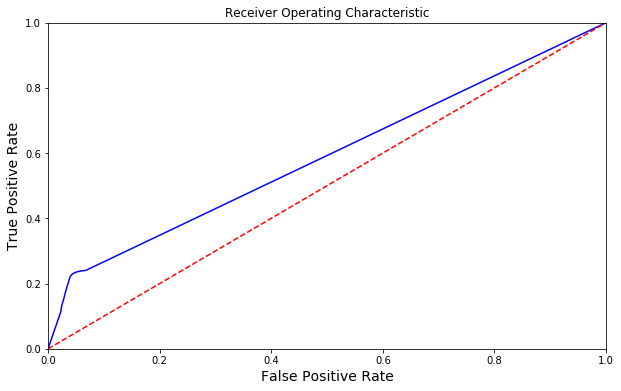

In [371]:
plot_ROC(dtree,y_test,dtree_pred)

Classification report 
              precision    recall  f1-score   support

          0       0.97      0.95      0.96    505496
          1       0.13      0.24      0.17     17075

avg / total       0.95      0.92      0.93    522571





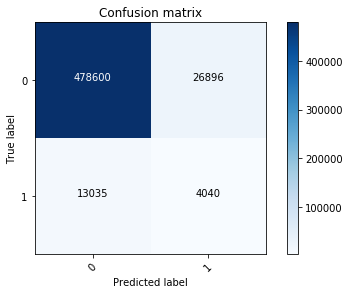

In [372]:
cm = confusion_matrix(y_test,dtree_pred)
target_names = ['0','1']
plot_confusion_matrix(cm, y_test,dtree_pred,classes=target_names,title='Confusion matrix')